# Feature Extraction

## Lab - 11

### Prepared By: Dr. Irfan

In [5]:
import numpy as np
from scipy import signal, misc, ndimage
from skimage import filters, feature, img_as_float
from skimage.io import imread
from skimage.color import rgb2gray
from PIL import Image, ImageFilter, ImageEnhance
import matplotlib.pylab as pylab

# ------------- This library is working for HARRIS corner detection
from skimage.feature import corner_harris, corner_subpix, corner_peaks

from skimage.transform import warp, SimilarityTransform, AffineTransform, resize
import cv2
from skimage import data
from skimage.util import img_as_float
from skimage.exposure import rescale_intensity
from skimage.measure import ransac


def plot_image(image, title=''):
    pylab.title(title, size=20), pylab.imshow(image)
    pylab.axis('off') # comment this line if you want axis ticks

--------
## Harris Corner Detector With scikit-image
------

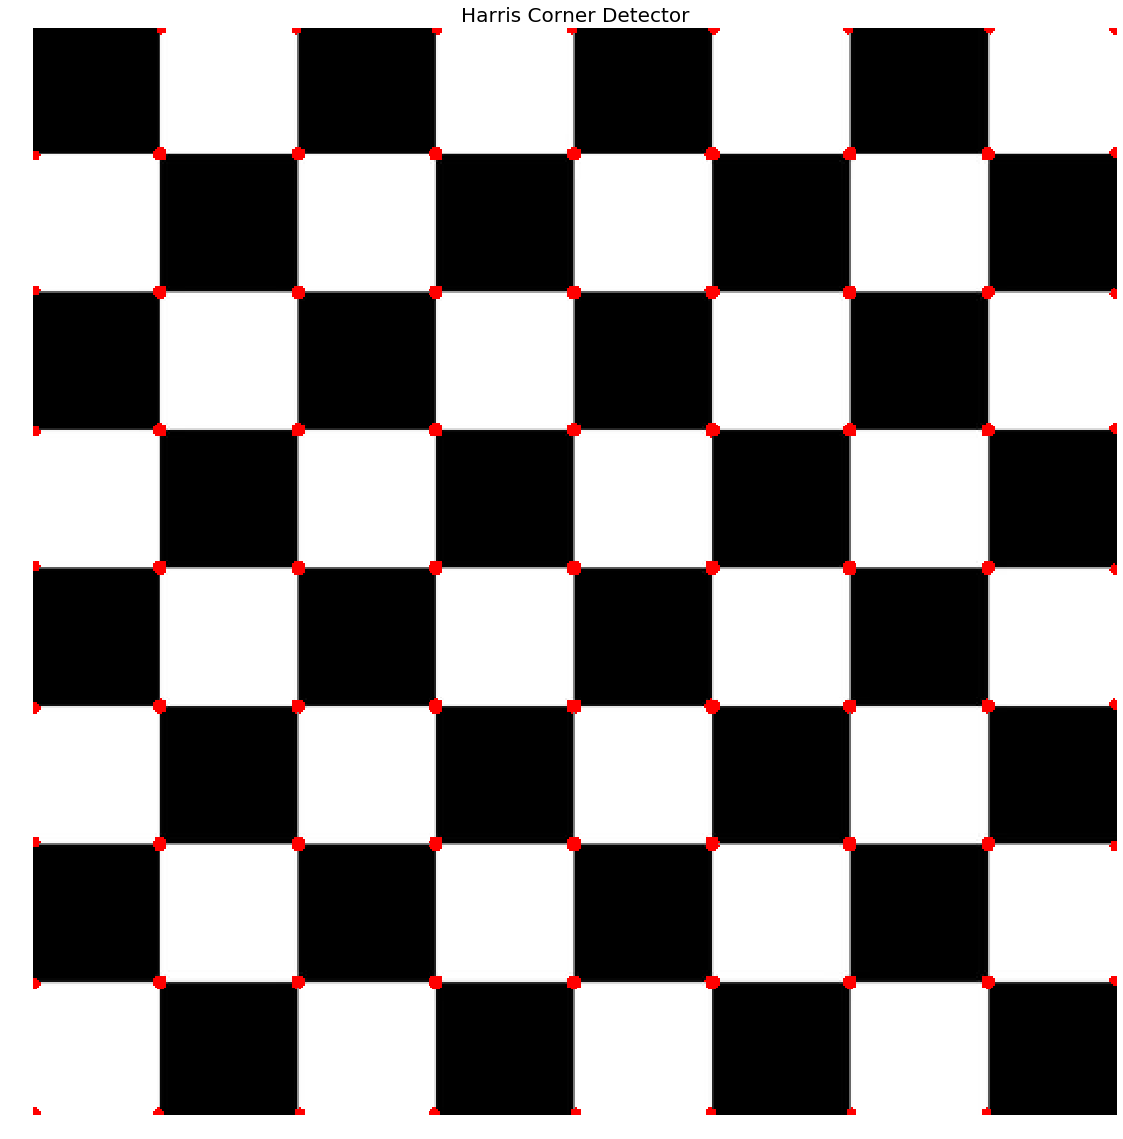

In [2]:
im = imread('images/chess.jpg') # RGB image

image_gray = rgb2gray(im)
coordinates = corner_harris(image_gray, k =0.001)

im[coordinates>0.01*coordinates.max()]=[255,0,0]#,255]  # for jpg image, [255,0,0,255]=[255,0,0]

pylab.figure(figsize=(30,20))
pylab.gray()
plot_image(im, 'Harris Corner Detector') 
pylab.show()




--------
## With sub-pixel accuracy
----------

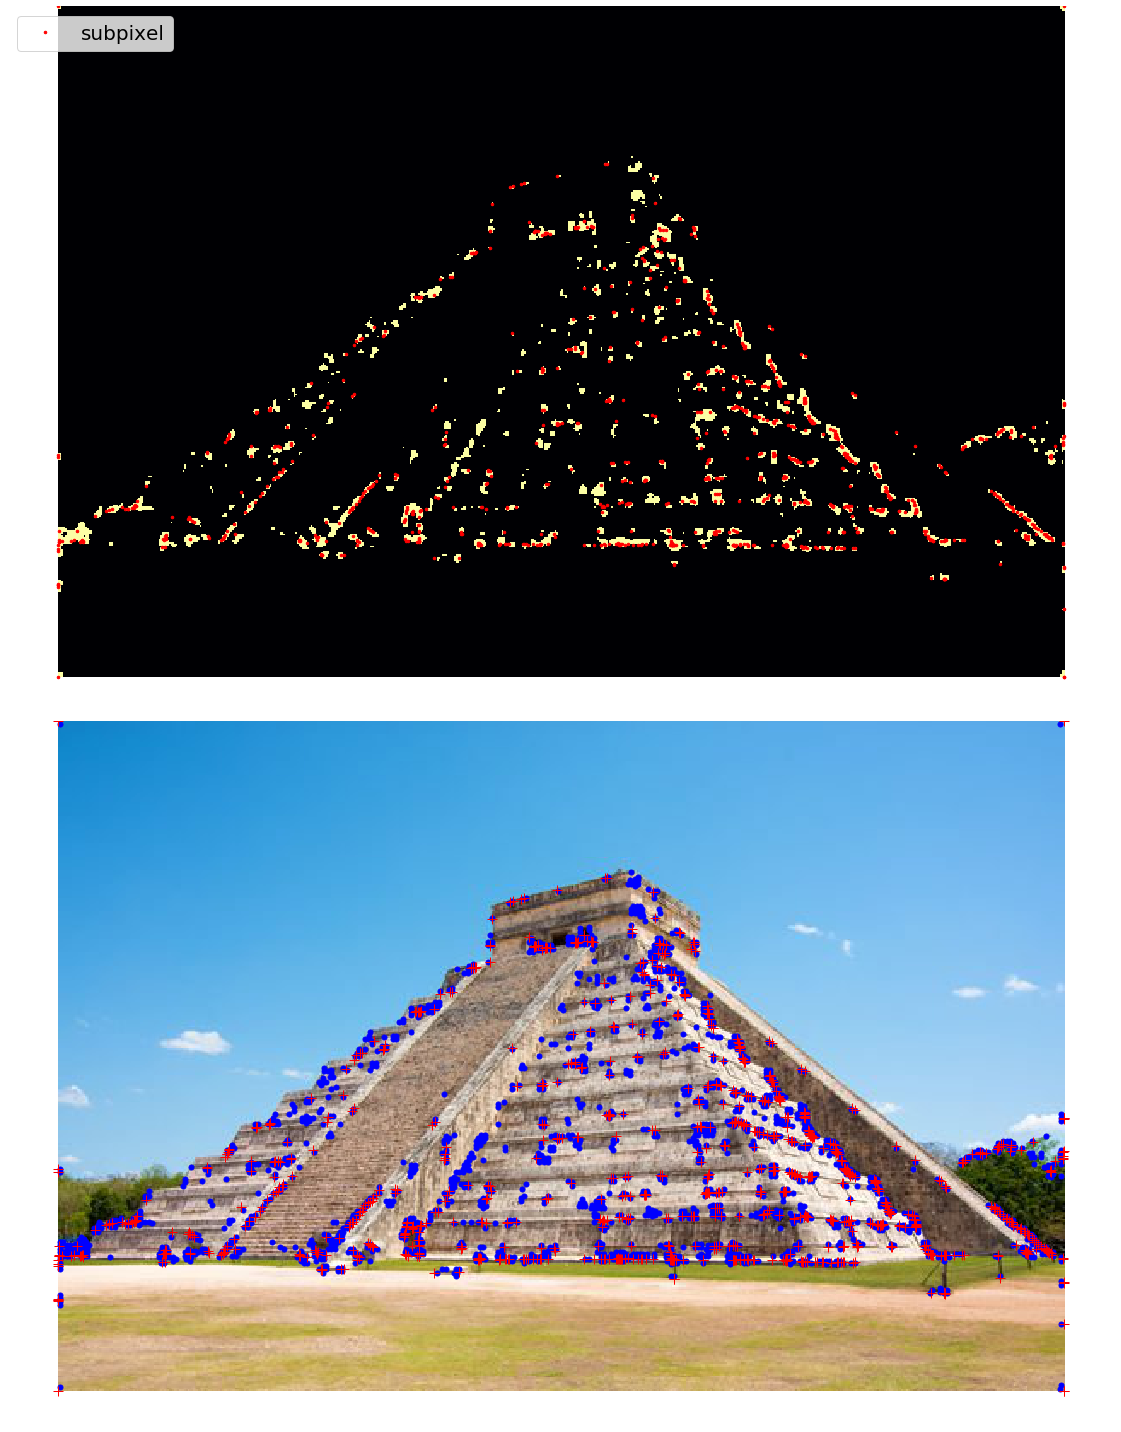

(None, None)

In [27]:
image = imread('images/pyramid.jpg')
image_gray = rgb2gray(image)

coordinates = corner_harris(image_gray, k =0.001)

coordinates[coordinates > 0.03*coordinates.max()] = 255 # threshold for an optimal value, depends on the image

corner_coordinates = corner_peaks(coordinates)
coordinates_subpix = corner_subpix(image_gray, corner_coordinates, window_size=11)

pylab.figure(figsize=(20,20))
pylab.subplot(211), pylab.imshow(coordinates, cmap='inferno')
pylab.plot(coordinates_subpix[:, 1], coordinates_subpix[:, 0], 'r.', markersize=5, label='subpixel')
pylab.legend(prop={'size': 20}), pylab.axis('off')

pylab.subplot(212), pylab.imshow(image, interpolation='nearest')
pylab.plot(corner_coordinates[:, 1], corner_coordinates[:, 0], 'bo', markersize=5)
pylab.plot(coordinates_subpix[:, 1], coordinates_subpix[:, 0], 'r+', markersize=10), pylab.axis('off')
pylab.tight_layout(), pylab.show()

------
## Application for Image Matching
--------

In [2]:
temple = rgb2gray(img_as_float(imread('images/B1.jpg')))

image_original = np.zeros(list(temple.shape) + [3])

image_original[..., 0] = temple

gradient_row, gradient_col = (np.mgrid[0:image_original.shape[0], 0:image_original.shape[1]] / float(image_original.shape[0]))


image_original[..., 1] = gradient_row
image_original[..., 2] = gradient_col

image_original = rescale_intensity(image_original)

image_original_gray = rgb2gray(image_original)

affine_trans = AffineTransform(scale=(1, 1), rotation=0.1, translation=(120, -20))
'''
An affine transformation is any transformation that preserves collinearity 
(i.e., all points lying on a line initially still lie on a line after transformation) 
and ratios of distances (e.g., the midpoint of a line segment remains the midpoint after transformation)

'''
image_warped = warp(image_original, affine_trans.inverse, output_shape=image_original.shape)

image_warped_gray = rgb2gray(image_warped)

coordinates = corner_harris(image_original_gray)
coordinates[coordinates > 0.01*coordinates.max()] = 1
coordinates_original = corner_peaks(coordinates, threshold_rel=0.0001, min_distance=5)

coordinates = corner_harris(image_warped_gray)
coordinates[coordinates > 0.01*coordinates.max()] = 1
coordinates_warped = corner_peaks(coordinates, threshold_rel=0.0001, min_distance=5)

coordinates_original_subpix = corner_subpix(image_original_gray, coordinates_original, window_size=9)
coordinates_warped_subpix = corner_subpix(image_warped_gray, coordinates_warped, window_size=9)

In [3]:
def gaussian_weights(window_ext, sigma=1):
    y, x = np.mgrid[-window_ext:window_ext+1, -window_ext:window_ext+1]
    g_w = np.zeros(y.shape, dtype = np.double)
    g_w[:] = np.exp(-0.5 * (x**2 / sigma**2 + y**2 / sigma**2))
    g_w /= 2 * np.pi * sigma * sigma
    return g_w

def match_corner(coordinates, window_ext=3):
    row, col = np.round(coordinates).astype(np.intp)
    window_original = image_original[row-window_ext:row+window_ext+1, col-window_ext:col+window_ext+1, :]
    weights = gaussian_weights(window_ext, 3)
    weights = np.dstack((weights, weights, weights))
    SSDs = []
    for coord_row, coord_col in coordinates_warped:
        window_warped = image_warped[coord_row-window_ext:coord_row+window_ext+1,
        coord_col-window_ext:coord_col+window_ext+1, :]
        if window_original.shape == window_warped.shape:
            SSD = np.sum(weights * (window_original - window_warped)**2)
            SSDs.append(SSD)
    min_idx = np.argmin(SSDs) if len(SSDs) > 0 else -1
    return coordinates_warped_subpix[min_idx] if min_idx >= 0 else [None]


In [4]:
from skimage.feature import (match_descriptors, corner_peaks, corner_harris, plot_matches, BRIEF)
source, destination = [], []
for coordinates in coordinates_original_subpix:
    coordinates1 = match_corner(coordinates)
    if any(coordinates1) and len(coordinates1) > 0 and not all(np.isnan(coordinates1)):
        source.append(coordinates)
        destination.append(coordinates1)

source = np.array(source)
destination = np.array(destination)
model = AffineTransform()
model.estimate(source, destination)
model_robust, inliers = ransac((source, destination), AffineTransform, min_samples=3, residual_threshold=2, max_trials=100)
outliers = inliers == False
print(affine_trans.scale, affine_trans.translation, affine_trans.rotation)
print(model.scale, model.translation, model.rotation)
print(model_robust.scale, model_robust.translation, model_robust.rotation)


C:\Users\Irfan\AppData\Local\Temp/ipykernel_16612/402051637.py:10: RuntimeWarning: overflow encountered in longlong_scalars
  window_original = image_original[row-window_ext:row+window_ext+1, col-window_ext:col+window_ext+1, :]


(1.0, 1.0) [120. -20.] 0.09999999999999999
(0.9953665901979837, 1.0142978279881514) [-20.71547279 129.40360716] -0.1181869732538603
(0.9999608858494027, 0.999982894844269) [-19.88671133 119.99238845] -0.09998726217656569


In [1]:
fig, axes = pylab.subplots(nrows=2, ncols=1, figsize=(20,15))
pylab.gray()
inlier_idxs = np.nonzero(inliers)[0]
plot_matches(axes[0], image_original_gray, image_warped_gray, source, destination, np.column_stack((inlier_idxs, inlier_idxs)),matches_color='b')
axes[0].axis('off'), axes[0].set_title('Correct correspondences', size=20)
outlier_idxs = np.nonzero(outliers)[0]
plot_matches(axes[1], image_original_gray, image_warped_gray, source, destination, np.column_stack((outlier_idxs, outlier_idxs)), matches_color='r')
axes[1].axis('off'), axes[1].set_title('Faulty correspondences', size=20)
fig.tight_layout(), pylab.show()

NameError: name 'pylab' is not defined

------------
## Blob detectors with LoG, DoG and DoH 
------------

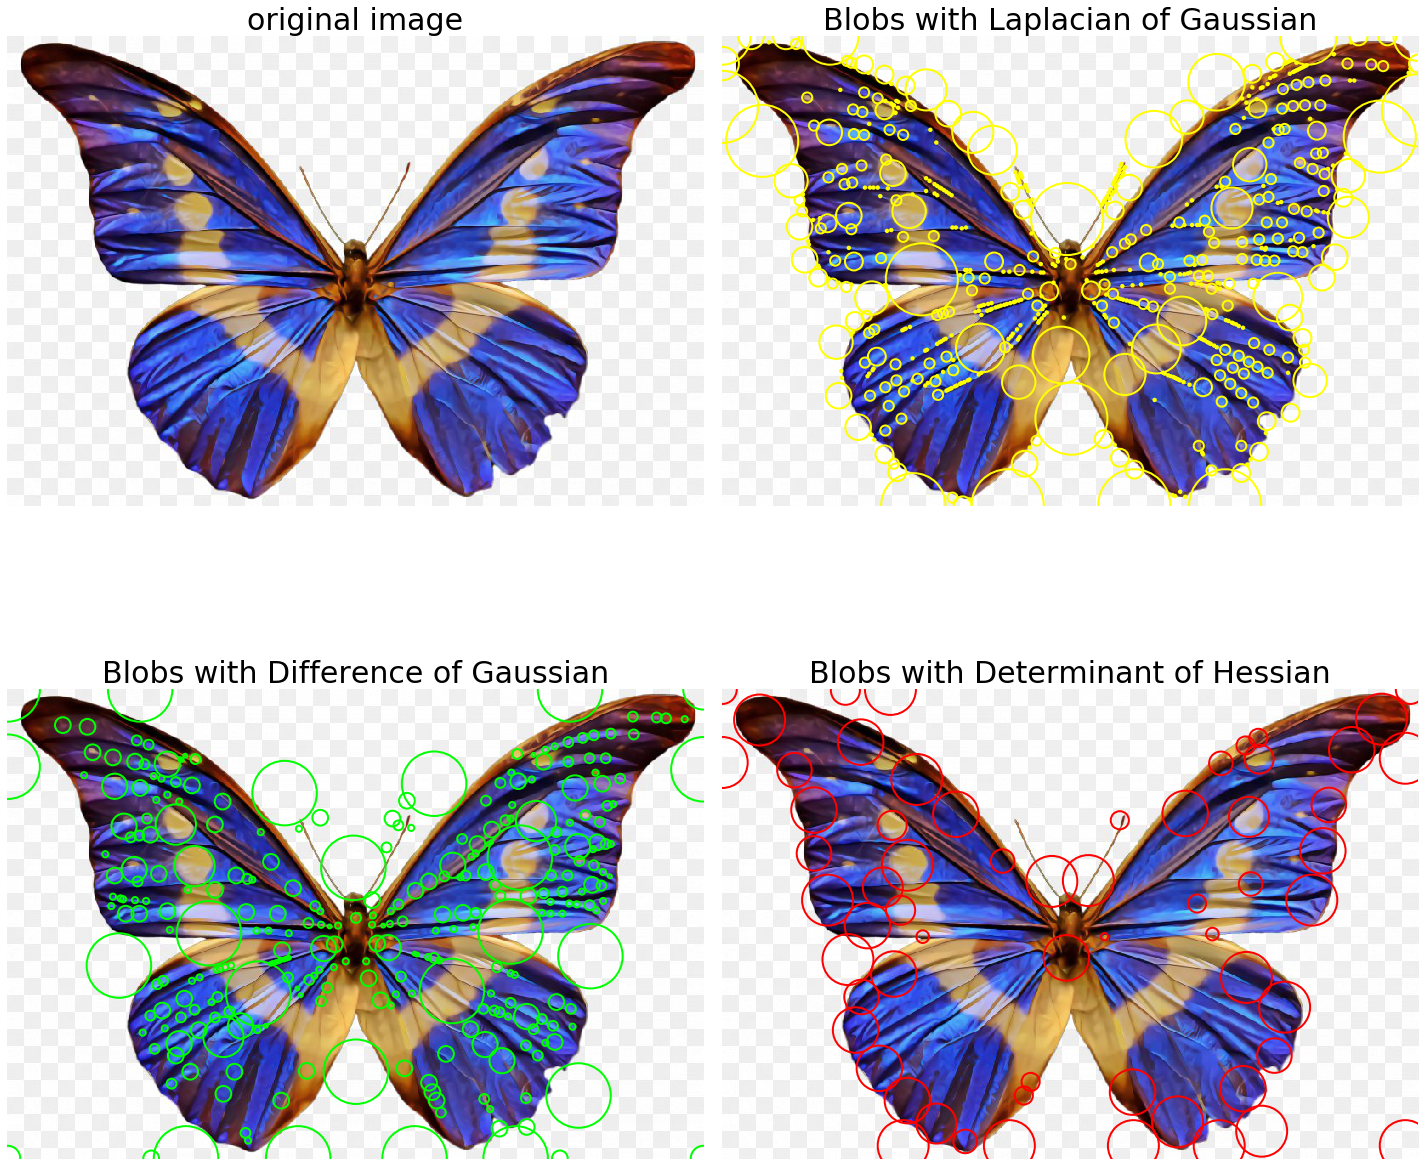

(None, None)

In [51]:
from numpy import sqrt
from skimage.feature import blob_dog, blob_log, blob_doh
im = imread('images/BF1.jpg')

im_gray = rgb2gray(im)

log_blobs = blob_log(im_gray, max_sigma=30, num_sigma=10, threshold=.1)
log_blobs[:, 2] = sqrt(2) * log_blobs[:, 2] # Compute radius in the 3rd column

dog_blobs = blob_dog(im_gray, max_sigma=30, threshold=0.1)
dog_blobs[:, 2] = sqrt(2) * dog_blobs[:, 2]

doh_blobs = blob_doh(im_gray, max_sigma=30, threshold=0.005)

list_blobs = [log_blobs, dog_blobs, doh_blobs]

colors, titles = ['yellow', 'lime', 'red'], ['Laplacian of Gaussian', 'Difference of Gaussian', 'Determinant of Hessian']
sequence = zip(list_blobs, colors, titles)

fig, axes = pylab.subplots(2, 2, figsize=(20, 20), sharex=True, sharey=True)
axes = axes.ravel()
axes[0].imshow(im, interpolation='nearest')
axes[0].set_title('original image', size=30), axes[0].set_axis_off()

for idx, (blobs, color, title) in enumerate(sequence):
    axes[idx+1].imshow(im, interpolation='nearest')
    axes[idx+1].set_title('Blobs with ' + title, size=30)
    for blob in blobs:
        y, x, row = blob
        col = pylab.Circle((x, y), row, color=color, linewidth=2, fill=False)
        axes[idx+1].add_patch(col), axes[idx+1].set_axis_off()
pylab.tight_layout(), pylab.show()

---------
## Compute HOG descriptors 
-------------

(225, 225) 1568


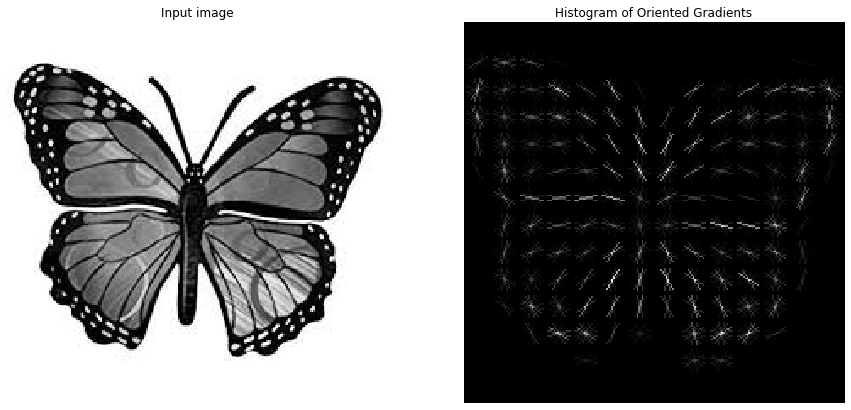

In [59]:
from skimage.feature import hog
from skimage import exposure

image = rgb2gray(imread('images/BF3.jpg'))

fd, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16),

                    cells_per_block=(1, 1), visualize=True)

print(image.shape, len(fd))

# ((256L, 256L), 2048)

fig, (axes1, axes2) = pylab.subplots(1, 2, figsize=(15, 10), sharex=True, sharey=True)
axes1.axis('off'), axes1.imshow(image, cmap=pylab.cm.gray), axes1.set_title('Input image')

hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

axes2.axis('off'), axes2.imshow(hog_image_rescaled, cmap=pylab.cm.gray),
axes2.set_title('Histogram of Oriented Gradients')

pylab.show()